## Test Half-Light Radii in spec-phot catalog
- Previous HLR from SExtractor "flux_radius" were too large for deblended objects
- Sanity + visual check spec-phot "fwhm" measure of HLR
- Does FWHM of 2D {Gaussian, Sersic} (what profile is assumed in SExtractor?) contain half the light?

In [1]:
import sys
sys.path.insert(0,'/data/emiln/XLSSC122_GalPops/Analysis/Modules/GalfitPyWrap')
import galfitwrap as gf
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import glob
from scipy import ndimage
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.io import fits
from astropy.io import ascii
from astropy import wcs
from astropy.table import Table, hstack, join
from __future__ import division
import fnmatch
import multiprocessing as mp
%matplotlib inline

# Make plots readable
# Update plot params
# Make plots readable
params = {'legend.fontsize': 18,
	  'figure.figsize': (6,5),
	 'axes.labelsize': 22,
	 'axes.titlesize':22,
	 'xtick.labelsize':18,
	 'ytick.labelsize':18}
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)
plt.rcParams.update(params)
# plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# plt.rc('text', usetex=True)
# plt.rc('text.latex', preamble=r'\usepackage{cmbright}')
# plt.rcParams.update(params)

/data/emiln/miniconda2/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
cat_file = '/data/emiln/XLSSC122_GalPops/Data/Products/HST/catalogs/xlssc122_F105_F140_redshifts_short_v4_snr_em_member2_by_hand.cat'
df = pd.read_csv(cat_file,delim_whitespace=True)

In [3]:
df.columns.values

array(['phot-id', 'ra', 'dec', 'f105_kron', 'f105_ekron', 'f105_0p8',
       'f105_e0p8', 'f140_kron', 'f140_ekron', 'f140_0p8', 'f140_e0p8',
       'asec_fwhm', 'zz', 'zlo', 'zhi', 'chi', 'spec-id', 'mcode', 'snr',
       'em-code', 'member1', 'member2'], dtype=object)

In [4]:
df['gold_cluster'] = 0
df['gold_foreground'] = 0
df['silver_cluster'] = 0
df.columns.values
df['(f140)kron'] = df['f140_kron']
for i,r in df.iterrows():
    if (r['member1']>0.5) and (r['(f140)kron']<24 or (r['(f140)kron']<24.5 and r['em-code']==1)):
#         print 'cluster mem'
        df.at[i,'gold_cluster'] = 1
    if (r['member1']<0.5 and r['member1']>0.1) and (r['(f140)kron']<24 or (r['(f140)kron']<24.5 and r['em-code']==1)):
#         print 'cluster mem'
        df.at[i,'silver_cluster'] = 1
    if (r['member2']>0.5) and (r['(f140)kron']<24 or (r['(f140)kron']<24.5 and r['em-code']==1)):
        df.at[i,'gold_foreground'] = 1  
print df['silver_cluster'].sum()
print df['gold_cluster'].sum()
print df['gold_foreground'].sum()
df['is_member'] = df.apply(lambda x: True if x.gold_cluster or x.silver_cluster else False, axis=1)

4
33
13


In [5]:
df = pd.read_csv('/data/emiln/XLSSC122_GalPops/Data/Products/HST/catalogs/spec_phot_v4_processed.cat')

/data/emiln/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


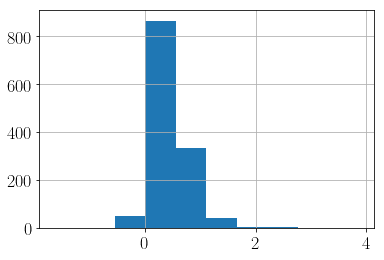

In [6]:
df['asec_fwhm'].hist()

In [7]:
df.columns.values

array(['phot-id', 'ra', 'dec', 'f105_kron', 'f105_ekron', 'f105_0p8',
       'f105_e0p8', 'f140_kron', 'f140_ekron', 'f140_0p8', 'f140_e0p8',
       'asec_fwhm', 'zz', 'zlo', 'zhi', 'chi', 'spec-id', 'mcode', 'snr',
       'em-code', 'member1', 'member2', 'gold_cluster', 'gold_foreground',
       'silver_cluster', '(f140)kron', 'is_member'], dtype=object)

In [8]:
member_df = df[df['is_member']]
member_df

,phot-id,ra,dec,f105_kron,f105_ekron,f105_0p8,f105_e0p8,f140_kron,f140_ekron,f140_0p8,...,mcode,snr,em-code,member1,member2,gold_cluster,gold_foreground,silver_cluster,(f140)kron,is_member
26,529,34.434215,-3.758796,22.0918,0.0259,23.8068,0.0312,20.6356,0.0102,22.3685,...,1,34.08530,0,1.000000,1.014880e-16,1,0,0,20.6356,True
40,455,34.422282,-3.763513,23.1633,0.0304,23.8435,0.0312,21.9504,0.0177,22.5527,...,1,22.31920,0,0.999998,5.068550e-10,1,0,0,21.9504,True
53,661,34.434096,-3.757658,23.1297,0.0479,24.2302,0.0389,21.6681,0.0170,22.7377,...,1,18.51870,0,0.999910,6.819980e-11,1,0,0,21.6681,True
57,1036,34.432450,-3.749924,23.7272,0.0435,24.1745,0.0375,22.3846,0.0218,22.8474,...,1,17.43010,0,0.999952,4.399920e-06,1,0,0,22.3846,True
59,300,34.435031,-3.767948,24.0850,0.0539,24.3496,0.0423,22.5026,0.0233,22.7896,...,1,16.91640,0,1.000000,1.134630e-22,1,0,0,22.5026,True
66,920,34.435628,-3.753143,23.2372,0.0302,23.3537,0.0271,22.7254,0.0254,22.9279,...,1,14.83810,1,0.999974,1.040860e-27,1,0,0,22.7254,True
75,305,34.447153,-3.768007,23.8277,0.0513,24.4884,0.0481,22.5249,0.0248,23.0674,...,1,11.84510,0,1.000000,0.000000e+00,1,0,0,22.5249,True
76,1057,34.436886,-3.750173,24.1777,0.0524,24.5021,0.0462,22.8479,0.0273,23.1308,...,1,11.80230,0,0.999931,3.796450e-07,1,0,0,22.8479,True
78,1065,34.435917,-3.749538,23.6267,0.0447,24.4200,0.0435,22.3414,0.0220,23.0740,...,1,11.22480,0,0.960674,2.042080e-02,1,0,0,22.3414,True
82,608,34.438450,-3.760699,24.2768,0.0510,24.4365,0.0433,22.9910,0.0285,23.1548,...,1,10.55160,0,0.982975,1.062590e-05,1,0,0,22.9910,True


In [9]:
import regions

In [31]:
region_filename = '/data/emiln/XLSSC122_GalPops/Data/Products/HST/catalogs/member_fwhm.reg'
region_list = []
for i,r in member_df.iterrows():
    center = SkyCoord(r.ra,r.dec,unit='deg')
    radius = Angle(r.asec_fwhm/2/60/60,'deg') # regions package only works with radii in degrees
    region = regions.CircleSkyRegion(center,radius)
    # region.visual = {'width':3}
    region.visual = {'color':'green'}
    region_list.append(region)

In [32]:
region.contains

<bound method CircleSkyRegion.contains of <CircleSkyRegion(<SkyCoord (ICRS): (ra, dec) in deg
    (34.446333, -3.743596)>, radius=0.000150873611111 deg)>>

In [33]:
# Write to file
# Need to update line 2 of saved file with global properties
# regions.write_ds9(region_list,region_filename)

In [38]:
region_filename

'/data/emiln/XLSSC122_GalPops/Data/Products/HST/catalogs/member_fwhm.reg'